# Dataframe for Dynamic Pricing

## Objectives

This document intends to briefly describe one alternative for the ETL process for the Dynamic Pricing problem at Olist.  
As the end product, we would like to have a table with the proper structure for forecasting techniques.  
The datasets will be described along the way.

### Importing packages

In [43]:
import pandas as pd
import datetime

### Dataframe with complete range

Let's start by creating a dataframe with every data point we want to measure. It will contain hourly intervals, equally spaced between two dates.  
You can change the parameters in the cell below:

In [2]:
freq = 'D' # 'H' is for hourly data. You can use 'D' for days, 'W' for last day of week, 'Q' for quarter, etc.

start_date = '1/1/2017' # MM/DD/YYYY
end_date = '4/1/2020' # MM/DD/YYYY

In [3]:
df = pd.DataFrame(data=pd.date_range(start=start_date, end=end_date, freq=freq),
                  columns=['date'])

df.head(2)

,date
0,2017-01-01
1,2017-01-02


In [4]:
df.tail(2)

,date
1185,2020-03-31
1186,2020-04-01


### Orders dataset

Let's investigate our first dataset "orders.csv". It contains information for every sale that was executed in a given period of time.  
Our main idea is to aggregate sales data and merge it with our dates dataframe (df).

In [5]:
# READING ORDERS DATA AND TRANSFORMING COLUMNS
orders = pd.read_csv('data/orders.csv', dtype={'product_gtin':'str','origin_zip':'str',
                                               'destination_zip':'str'})

orders['purchase_timestamp'] = pd.to_datetime(orders['purchase_timestamp'])

In [6]:
orders.head()

,purchase_timestamp,seller_id,product_gtin,product_sku,channel_slug,channel_store,price,freight_value,price_freight_shift,commission_product_olist,commission_freight_olist,origin_zip,origin_state,origin_city,destination_zip,destination_state,destination_city
0,2019-07-20 11:19:43,a97001a2-a7d2-4bd6-b0d5-1da2a2b8abd9,6952202281890,PRDWRHUYLLMFX2U0,mercadolivre,mercadolivre,82.99,20.86,0.0,0.20,0.20,01109010,SP,SAO PAULO,89265575,SC,Jaraguá do Sul
1,2019-11-11 20:43:23,a97001a2-a7d2-4bd6-b0d5-1da2a2b8abd9,6951003643197,PRDACYVT895VMO7H,mercadolivre,mercadolivre,119.90,0.00,0.0,0.20,0.20,01109010,SP,SAO PAULO,06040470,SP,Osasco
2,2020-03-01 16:25:00,c58b83e5-52de-43fe-8399-a7bc312e2aa5,7898907175302,PRDKTDU50G9FVV57,cnova,ex,39.90,14.24,0.0,0.19,0.19,20910970,RJ,RIO DE JANEIRO,22260210,RJ,Rio de Janeiro
3,2020-02-04 12:04:10,a97001a2-a7d2-4bd6-b0d5-1da2a2b8abd9,6951003643197,PRDACYVT895VMO7H,mercadolivre,mercadolivre,130.95,0.00,0.0,0.20,0.20,01109010,SP,SAO PAULO,89062100,SC,Blumenau
4,2018-12-14 13:52:19,a97001a2-a7d2-4bd6-b0d5-1da2a2b8abd9,6951003643197,PRDACYVT895VMO7H,mercadolivre,mercadolivre,128.99,21.51,0.0,0.20,0.20,01109010,SP,SAO PAULO,66055000,PA,Belém


In [7]:
orders.product_gtin.nunique()

647

###### Selecting specific product

In the orders dataset, we have sales information for 647 different products.  
For simplification purposes, let's choose one single product for analysis and manipulation of the dataset.  
To do so, choose a single gtin (str) in the cell below.

- gtin = '7908243600137'
- product_sku = 'PRD41RHHBF9NQR74'
- canonical_sku = 'PRDIM5XOLWMUM0HU'


In [8]:
# SELECTED GTIN

gtin = '7908243600137'

In [8]:
# FILTERING ORDERS DATASET BY CHOSEN GTIN

filter_orders = orders[['purchase_timestamp','product_gtin',
                        'price','freight_value',
                        'commission_product_olist','commission_freight_olist']].copy()

# ADD ARTIFICIAL COLUMN WITH THE NUMBER OF ORDERS -> WILL BE USED TO COUNT THE ORDERS BY HOUR
filter_orders['orders'] = 1


# GROUPS ORDERS BY CHOSEN FREQUENCY
filter_orders = filter_orders.groupby([pd.Grouper(key='purchase_timestamp', freq=freq),'product_gtin'])\
                  .agg({'price':'mean', 
                        'freight_value':'mean',
                        'commission_product_olist':'mean',
                        'commission_freight_olist':'mean',
                        'orders':'sum'}).reset_index()

In [9]:
filter_orders.head()

,purchase_timestamp,product_gtin,price,freight_value,commission_product_olist,commission_freight_olist,orders
0,2015-09-23,7899893323067,168.0,0.000,0.2,0.0,1
1,2015-10-13,7899893323067,168.0,0.000,0.2,0.0,1
2,2016-04-16,7898152189550,343.9,17.060,0.2,0.0,1
3,2016-06-10,7897889805825,129.9,28.540,0.2,0.0,3
4,2016-06-11,7897889805825,129.9,32.534,0.2,0.0,5


##### merge date_range dataframe and orders

Now that we have the number of sales of a given product by hour, along with its average price, average shipping values and average commissions (percentage), we can join with our date range dataframe.  

The 'NaN' rows are the ones that did not have any sales.

In [10]:
# MERGE DF and Filter orders

merged = pd.merge(df, filter_orders, how='left', left_on='date', right_on='purchase_timestamp')
merged.drop('purchase_timestamp', axis=1, inplace=True)

In [13]:
merged.head()

,date,product_gtin,price,freight_value,commission_product_olist,commission_freight_olist,orders
0,2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Checking some rows with sales

merged[merged['orders'].notnull()].head()

,date,product_gtin,price,freight_value,commission_product_olist,commission_freight_olist,orders
5,2017-01-06,7891530258930,579.99,28.55,0.2,0.0,1.0
7,2017-01-08,7898914878487,66.90,18.75,0.2,0.0,1.0
8,2017-01-09,7898914878487,66.90,18.75,0.2,0.0,2.0
10,2017-01-11,7891530258930,579.99,18.23,0.2,0.0,1.0
11,2017-01-11,7897889805825,129.99,29.19,0.2,0.0,1.0


### Product_info dataset

Another available dataset is the "product_info.csv". We will use it to check when a product was created in our database to fine tune the starting point of our time series.

In [15]:
prod_info = pd.read_csv('data/product_info.csv', dtype={'gtin':'str'})

prod_info['created_at'] = pd.to_datetime(prod_info['created_at'])

# product creation date

# Get minimum creation date
# filter_prod = prod_info[prod_info['gtin']==gtin][['gtin','created_at']]
# filter_prod = filter_prod[filter_prod['created_at']==min(filter_prod['created_at'])]
# filter_prod = filter_prod.groupby(pd.Grouper(key='created_at',freq=freq)).min().reset_index()

In [17]:
filter_prod = prod_info[['created_at','gtin','name']]

In [20]:
filter_prod = filter_prod.groupby(['gtin','name']).min().reset_index()

In [21]:
filter_prod.head()

,gtin,name,created_at
0,1001001118649,"Esqueleto 170 cm, Padrão, com Suporte e Base c...",2019-06-03 14:50:41
1,1003001113372,Autoclave Vertical 18 Litros,2019-06-21 13:05:50
2,1003001209488,"Mini Centrífuga Para 8 Microtubos Vol. 0,2 A 2...",2019-12-02 12:38:41
3,1234567896618,"Veda Fresta De Portão 6,4 Cm Altura Vedapratic...",2019-07-01 09:24:29
4,1286508320126,Diabete composto 90 Cápsulas 500 Mg insulina n...,2019-01-24 13:10:00


In [33]:
filter_prod['created_at'][0].day

3

In [44]:
def truncate_date(x):
    return datetime.date(x.year,x.month,x.day)

In [45]:
filter_prod['created_date'] = filter_prod['created_at'].map(truncate_date)

In [47]:
filter_prod.head()

,gtin,name,created_at,created_date
0,1001001118649,"Esqueleto 170 cm, Padrão, com Suporte e Base c...",2019-06-03 14:50:41,2019-06-03
1,1003001113372,Autoclave Vertical 18 Litros,2019-06-21 13:05:50,2019-06-21
2,1003001209488,"Mini Centrífuga Para 8 Microtubos Vol. 0,2 A 2...",2019-12-02 12:38:41,2019-12-02
3,1234567896618,"Veda Fresta De Portão 6,4 Cm Altura Vedapratic...",2019-07-01 09:24:29,2019-07-01
4,1286508320126,Diabete composto 90 Cápsulas 500 Mg insulina n...,2019-01-24 13:10:00,2019-01-24


##### Filter merged based on creation date

In [50]:
merged = pd.merge(merged, filter_prod, left_on='product_gtin', right_on='gtin', how='left')

In [51]:
# Exclude rows not necessary 
merged.head()

,date,product_gtin,price,freight_value,commission_product_olist,commission_freight_olist,orders,gtin,name,created_at,created_date
0,2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN


In [17]:
# filter merged dataframe to keep only the dates after the creation date.
merged = merged[merged['date']>=creation_date].copy()

# fill gtin backfill information
merged['product_gtin'] = merged['product_gtin'].fillna(method='bfill')
merged['product_gtin'] = merged['product_gtin'].fillna(method='ffill')
# fill NaN orders with 0 - no orders on that timestamp
merged['orders'] = merged['orders'].fillna(value=0)

In [18]:
merged.head()

,date,product_gtin,price,freight_value,commission_product_olist,commission_freight_olist,orders
803,2019-03-15,7908243600137,NaN,NaN,NaN,NaN,0.0
804,2019-03-16,7908243600137,NaN,NaN,NaN,NaN,0.0
805,2019-03-17,7908243600137,NaN,NaN,NaN,NaN,0.0
806,2019-03-18,7908243600137,NaN,NaN,NaN,NaN,0.0
807,2019-03-19,7908243600137,NaN,NaN,NaN,NaN,0.0


In [19]:
merged.reset_index(drop=True, inplace=True)

### Competition

Now, let's get our competitor's prices by the same frequency.

In [20]:
# Read data and format it
competition = pd.read_csv('data/competition.csv', dtype={'gtin':'str'})

competition['updated_at'] = pd.to_datetime(competition['updated_at'])

# FILTER GTIN
competition = competition[competition['gtin'] == gtin]

In [21]:
competition.head()

,updated_at,gtin,value,slug
41107,2019-12-19 13:24:33,7908243600137,172.70,sieve-b2w-shoptime
41108,2019-12-18 10:51:29,7908243600137,155.43,sieve-b2w-shoptime
41109,2019-12-18 10:50:54,7908243600137,172.70,olist-carrefour
41110,2019-12-18 10:45:32,7908243600137,172.70,olist-b2w
41111,2019-12-18 10:31:49,7908243600137,172.70,olist-cnova


In [22]:
# filter competition on extremely low and high prices
std = competition['value'].std()
mean = competition['value'].mean()

competition = competition[(competition['value']>= mean-3*std) & (competition['value']<= mean+3*std)]

In [23]:
# Group by freq and get minimum value
competition = competition.groupby([pd.Grouper(key='updated_at', freq=freq),'gtin']).min()[['value']].reset_index()

In [24]:
competition.head()

,updated_at,gtin,value
0,2019-03-15,7908243600137,217.8
1,2019-03-19,7908243600137,217.8
2,2019-03-21,7908243600137,199.8
3,2019-04-03,7908243600137,219.9
4,2019-04-08,7908243600137,219.9


##### merge competition prices with merged dataframe

In [25]:
#merged['day'] = merged['date'].apply(lambda x: x.date())

In [26]:
merged = pd.merge(merged, competition,
         left_on=['date','product_gtin'], right_on=['updated_at', 'gtin'],
         how='left')

merged.rename(columns={'value':'competition_price'}, inplace=True)

merged = merged[['date', 'product_gtin',  'competition_price', 'price', 'freight_value',
       'commission_product_olist', 'commission_freight_olist', 'orders']].copy()

In [27]:
merged.head()

,date,product_gtin,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders
0,2019-03-15,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0
1,2019-03-16,7908243600137,NaN,NaN,NaN,NaN,NaN,0.0
2,2019-03-17,7908243600137,NaN,NaN,NaN,NaN,NaN,0.0
3,2019-03-18,7908243600137,NaN,NaN,NaN,NaN,NaN,0.0
4,2019-03-19,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0


We will forward fill the competition price.

In [28]:
merged['competition_price'].fillna(method='ffill', inplace=True)

In [29]:
merged.head()

,date,product_gtin,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders
0,2019-03-15,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0
1,2019-03-16,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0
2,2019-03-17,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0
3,2019-03-18,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0
4,2019-03-19,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0


In [30]:
merged.tail()

,date,product_gtin,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders
379,2020-03-28,7908243600137,161.4,NaN,NaN,NaN,NaN,0.0
380,2020-03-29,7908243600137,161.4,NaN,NaN,NaN,NaN,0.0
381,2020-03-30,7908243600137,161.4,NaN,NaN,NaN,NaN,0.0
382,2020-03-31,7908243600137,161.4,NaN,NaN,NaN,NaN,0.0
383,2020-04-01,7908243600137,161.4,NaN,NaN,NaN,NaN,0.0


### Product type and group

Let's gather some information about the type of the analyzed product.

This particular gtin belongs to the product_type "Kit para cabelo" (Hair Care Kit).  
The product belongs to the broader group "beleza_saude" (beauty_health)

In [31]:
product_type = pd.read_csv('data/product_type.csv', dtype={'value':str})

product_type.head()

product_type[product_type['value']==gtin]

merged.columns

merged = pd.merge(left=merged, right=product_type,
         left_on='product_gtin', right_on='value')[['date', 'product_gtin', 'competition_price',
                                                    'price', 'freight_value', 'commission_product_olist', 
                                                    'commission_freight_olist', 'orders','product_type', 
                                                    'product_type_group']]

In [32]:
merged.head()

,date,product_gtin,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,product_type,product_type_group
0,2019-03-15,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0,Kit para cabelo,beleza_saude
1,2019-03-16,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0,Kit para cabelo,beleza_saude
2,2019-03-17,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0,Kit para cabelo,beleza_saude
3,2019-03-18,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0,Kit para cabelo,beleza_saude
4,2019-03-19,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0,Kit para cabelo,beleza_saude


### Olist history of prices
### TODO

For this particular case, we will only read historical data for the selected gtin. This will be changed once olist can share data on other products.  
Due to internal issues, the price history could not be gathered.


In [33]:
# history = pd.read_csv('data/product_history.csv', dtype={'gtin':str})
# history['updated_at'] = pd.to_datetime(history['updated_at'])

### SOME CHARTS

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [38]:
merged.columns

Index(['date', 'product_gtin', 'competition_price', 'price', 'freight_value',
       'commission_product_olist', 'commission_freight_olist', 'orders',
       'product_type', 'product_type_group'],
      dtype='object')

In [41]:
trace0 = go.Scatter(x=merged.date,
                   y=merged.orders, mode='lines')

trace1 = go.Scatter(x=merged.date,
                    y=merged.competition_price, mode='markers')

trace2 = go.Scatter(x=merged.date,
                    y=merged.price,
                    mode='markers')

trace3 = go.Scatter(x=merged.date,
                    y=merged.freight_value,
                    mode='lines')


iplot([trace0, trace1, trace2, trace3])

/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



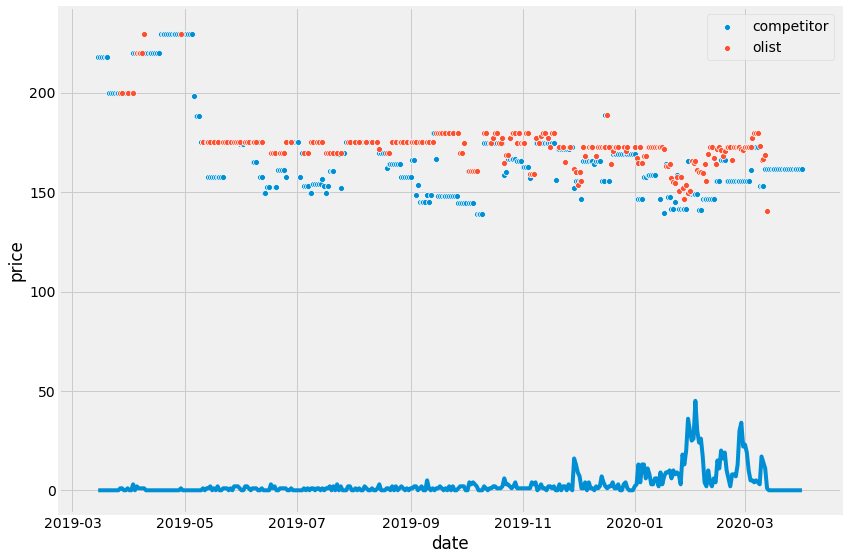

In [36]:
plt.figure(figsize=(12,8))

plt.style.use('fivethirtyeight')

sns.lineplot(x='date', y='orders', data=merged)
sns.scatterplot(x='date', y='competition_price', data=merged, label='competitor')
sns.scatterplot(x='date', y='price', data=merged, label='olist')

plt.legend()

plt.tight_layout()
plt.show()

In [37]:
sum(merged['orders'])

1187.0